### Data from: https://archive.ics.uci.edu/dataset/292/wholesale+customers

## Dataset: Wholesale Customers

### Description
The Wholesale Customers dataset contains annual spending information of customers
on various product categories. The goal is to segment customers based on their
purchasing behavior using unsupervised machine learning techniques.

### Rows
- 440 customers

### Columns
| Column | Type | Description |
|------|----|-------------|
| Channel | Categorical | Customer channel (1 = Horeca, 2 = Retail) |
| Region | Categorical | Customer region (1 = Lisbon, 2 = Oporto, 3 = Other) |
| Fresh | Numerical | Annual spending on fresh products |
| Milk | Numerical | Annual spending on milk products |
| Grocery | Numerical | Annual spending on grocery products |
| Frozen | Numerical | Annual spending on frozen products |
| Detergents_Paper | Numerical | Annual spending on detergents and paper |
| Delicassen | Numerical | Annual spending on delicatessen products |

### Machine Learning Task
- Type: Unsupervised Learning
- Objective: Customer Segmentation (Clustering)

### Expected Output
- A cluster label representing customer segment

### Assumptions
- No missing values
- Spending values are non-negative
- Outliers represent real business behavior and should not be removed


# 1️⃣ Imports & Config

In [11]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 41


# 2️⃣ Load Dataset

In [12]:
df = pd.read_csv("Dataset/Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [13]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


# 3️⃣ Basic Data Validation (Production Mindset)

In [15]:
expected_columns = [
    "Channel", "Region", "Fresh", "Milk", "Grocery",
    "Frozen", "Detergents_Paper", "Delicassen"
]

assert all(col in df.columns for col in expected_columns), "Schema mismatch"
assert (df[expected_columns[2:]] >= 0).all().all(), "Negative values found"
assert df["Channel"].isin([1, 2]).all(), "Invalid Channel values"
assert df["Region"].isin([1, 2, 3]).all(), "Invalid Region values"

# 4️⃣ Feature Separation

In [16]:
categorical_cols = ["Channel"]
numerical_cols = [
    "Fresh", "Milk", "Grocery",
    "Frozen", "Detergents_Paper", "Delicassen"
]

# Region is intentionally excluded (usually weak signal)

# 5️⃣ Log Transformation (Critical)

In [17]:
X_num = np.log1p(df[numerical_cols])

# Why?

# Reduces skew
# Prevents Grocery / Fresh from dominating distance

# 6️⃣ Encode Categorical Feature

In [18]:
X_cat = pd.get_dummies(df[categorical_cols], drop_first=True)

In [20]:
X_cat

,Channel
0,2
1,2
2,2
3,1
4,2
...,...
435,1
436,1
437,2
438,1


# 7️⃣ Combine Features

In [ ]:
X_num # log values for numerical columns

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682
2,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632
3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412
4,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718
...,...,...,...,...,...,...
435,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483
436,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893
437,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624
438,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998


In [ ]:
df[numerical_cols] # Original values

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


In [24]:
X = pd.concat([X_num, X_cat], axis=1)

In [25]:
X

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,2
1,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,2
2,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,2
3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,1
4,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,2
...,...,...,...,...,...,...,...
435,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483,1
436,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893,1
437,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624,2
438,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998,1


# 8️⃣ Scaling (MANDATORY for Clustering)

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Why RobustScaler?

# Handles extreme spenders better than StandardScaler

# 9️⃣ Dimensionality Reduction (PCA)

In [30]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of PCA components: {X_pca.shape[1]}")

Number of PCA components: 4


# 🔟 Choosing Optimal Clusters (k)

In [31]:
silhouette_scores = []

for k in range(2, 9):
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = model.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append((k, score))

silhouette_scores


[(2, 0.29581210204523317),
 (3, 0.2781861874913572),
 (4, 0.2314888892422148),
 (5, 0.24196748210716135),
 (6, 0.205694905824904),
 (7, 0.21114573110796736),
 (8, 0.20917038844930536)]

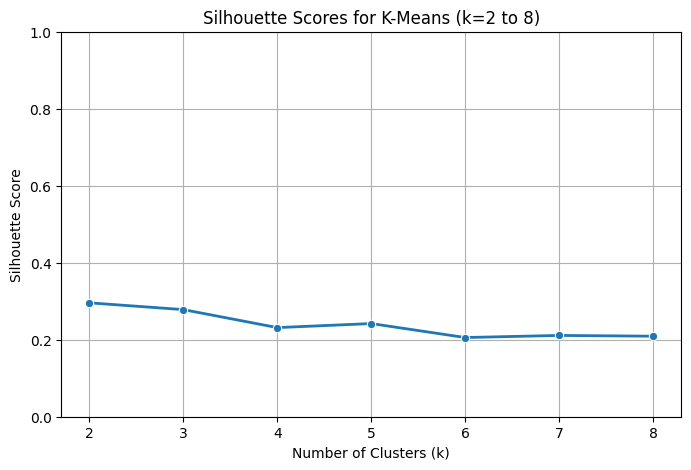

In [32]:
k_values = [score[0] for score in silhouette_scores]
scores = [score[1] for score in silhouette_scores]
plt.figure(figsize=(8, 5))
sns.lineplot(x=k_values, y=scores, marker='o', linewidth=2)
plt.title('Silhouette Scores for K-Means (k=2 to 8)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.ylim(0, 1)
plt.show()


# 1️⃣1️⃣ Train Final Model

In [33]:
optimal_k = 2

kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=RANDOM_STATE
)

clusters = kmeans.fit_predict(X_pca)
df["cluster"] = clusters


# 1️⃣2️⃣ Cluster Profiling (VERY IMPORTANT)

In [ ]:
cluster_profile = (
    df
    .groupby("cluster")[numerical_cols]
    .mean()
    .round(2)
)

cluster_profile

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0,14079.82,2670.65,3093.52,4013.69,513.12,1152.46
1,8996.54,10311.04,14968.03,1711.61,6302.48,2062.79


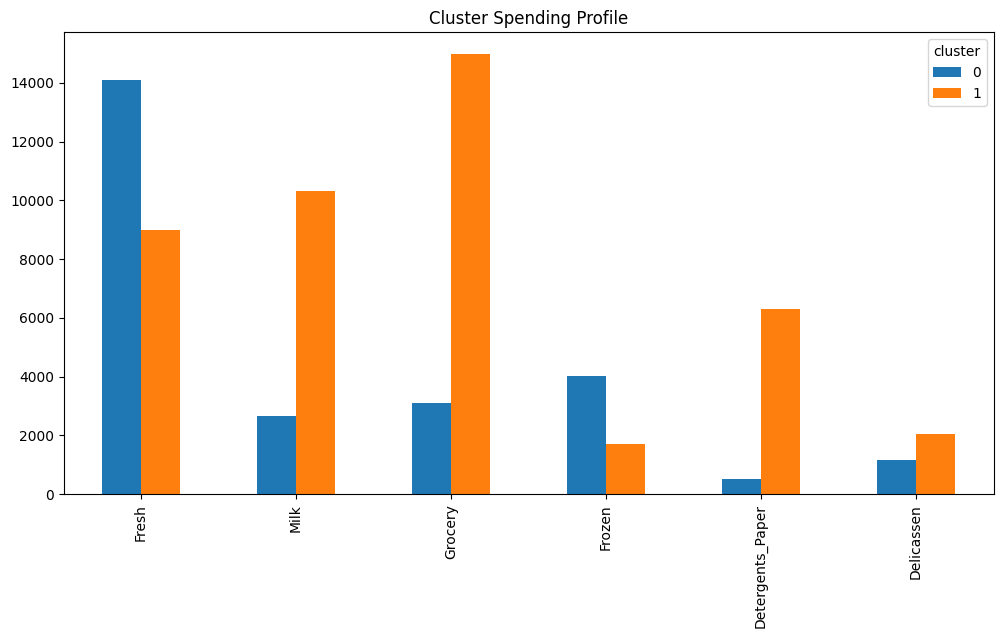

In [35]:
cluster_profile.T.plot(kind="bar", figsize=(12,6))
plt.title("Cluster Spending Profile")
plt.show()

# 1️⃣3️⃣ Sanity Checks Before Production

In [36]:
# Cluster sizes
df["cluster"].value_counts(normalize=True)

# No empty clusters
assert df["cluster"].nunique() == optimal_k

# 1️⃣4️⃣ Save Training Artifacts (CRITICAL)

In [37]:
joblib.dump(kmeans, "Models/kmeans_model.pkl")
joblib.dump(scaler, "Models/scaler.pkl")
joblib.dump(pca, "Models/pca.pkl")
joblib.dump(list(X.columns), "Models/feature_order.pkl")

['Models/feature_order.pkl']